## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [1]:
# import libraries
import re
import numpy as np
import pandas as pd
import assets.script as sc
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

In [2]:
# import sql library
from psycopg2 import sql
import psycopg2 as pg

# define paths
from pathlib import Path
data_path = Path('./data')

In [3]:
# display table names
display_tables = sc.sql_read_tables()
for tables in display_tables:
    print(tables)

flights
flights_test
fuel_comsumption
pass_sample
passengers
sample
test_table


In [4]:
# query for tables
limit = 100000
sample_size = '{}k'.format(int(limit/1000))


for tables in display_tables:
    query = sql.SQL(
        "SELECT * FROM {t} \
            LIMIT {l};").format(
            t = sql.Identifier(tables),
            l = sql.Literal(limit)
        )
        
    filename = '{}_{}_sample.csv'.format(tables, sample_size)
    overwrite = False
    
    # sql call
    df = sc.make_csv(query, filename, overwrite)

File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...
File exists. Returning DataFrame...


In [5]:
# transfer sample of tables to dataframes
df_flights = pd.read_csv(data_path / 'flights_{}_sample.csv'.format(sample_size))
df_flights_test = pd.read_csv(data_path / 'flights_test_{}_sample.csv'.format(sample_size))
df_fuel_comsumption = pd.read_csv(data_path / 'fuel_comsumption_{}_sample.csv'.format(sample_size))
df_pass_sample = pd.read_csv(data_path / 'pass_sample_{}_sample.csv'.format(sample_size))
df_passengers = pd.read_csv(data_path / 'passengers_{}_sample.csv'.format(sample_size))
df_sample = pd.read_csv(data_path / 'sample_{}_sample.csv'.format(sample_size))
df_test_table = pd.read_csv(data_path / 'test_table_{}_sample.csv'.format(sample_size))

df_table_names = [df_flights, df_flights_test, df_fuel_comsumption, df_pass_sample, df_passengers, df_sample, df_test_table]

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

##### Look for columns describing delay

In [6]:
# search for columns that describe delays
regex = r"(.*delay.*)"
indices, results = sc.search_data(df_flights, regex)
results

['dep_delay',
 'arr_delay',
 'carrier_delay',
 'weather_delay',
 'nas_delay',
 'security_delay',
 'late_aircraft_delay']

##### Preliminary EDA

In [7]:
print(df_flights[results].isnull().sum())
# most delays appear to have many missing values; will ignore them for now

dep_delay               3133
arr_delay               3723
carrier_delay          73689
weather_delay          73689
nas_delay              73689
security_delay         73689
late_aircraft_delay    73689
dtype: int64


In [8]:
# early arrivals|departures without null values
df_flights_delay = df_flights[['dep_delay', 'arr_delay']].dropna().reset_index(drop=True)
print(df_flights_delay.isnull().sum())
print(df_flights_delay.index)
df_flights_delay.describe()

dep_delay    0
arr_delay    0
dtype: int64
RangeIndex(start=0, stop=96277, step=1)


,dep_delay,arr_delay
count,96277.000000,96277.000000
mean,21.840512,17.573450
std,68.435427,70.287878
min,-32.000000,-88.000000
25%,-5.000000,-13.000000
50%,-1.000000,-3.000000
75%,17.000000,18.000000
max,1615.000000,1597.000000


These numbers are terrible.

##### Check for normal distributions

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.46445733308792114 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 16281.315486526786 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 6.635684409030094
kurtosis, tail spread (< 3 is best): 73.27290163045704


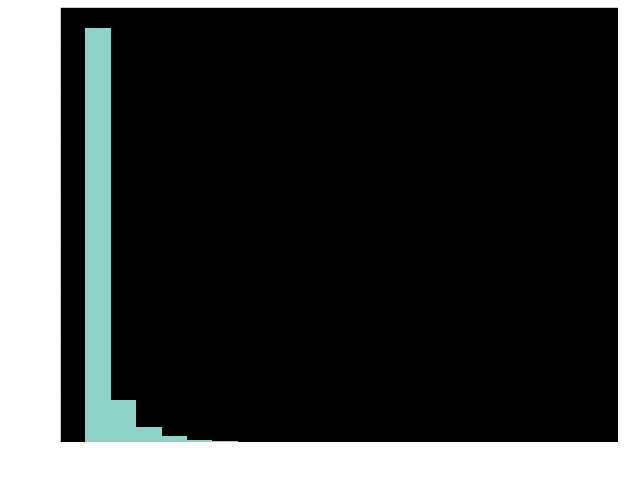

In [9]:
sc.check_normal_dist(df_flights_delay['dep_delay'])

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.5947854518890381 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 12638.842786035922 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 6.209374232134813
kurtosis, tail spread (< 3 is best): 66.36765450338011


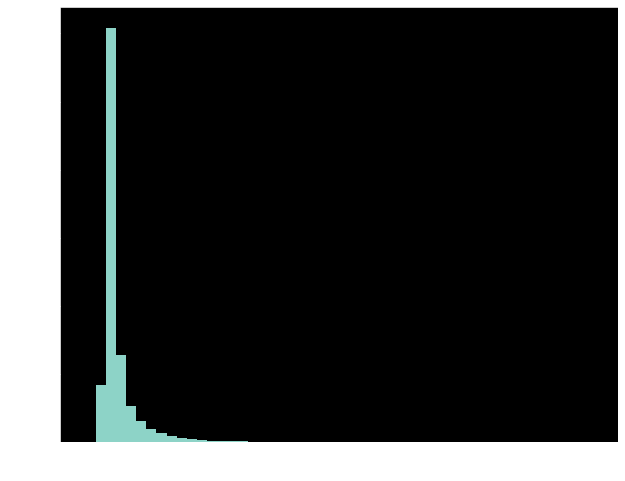

In [10]:
sc.check_normal_dist(df_flights_delay['arr_delay'], bins=50)

These are really not normal. Also, extremely skewed.

##### Filter outliers and redo the normal distribution checks

In [11]:
df = sc.filter_outliers(df_flights_delay, df_flights_delay['arr_delay'])
df.reset_index(inplace=True, drop=True)
df = sc.filter_outliers(df, df['dep_delay'])

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.8135808706283569 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 5865.607979487759 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 1.9776802142480534
kurtosis, tail spread (< 3 is best): 4.470678047775033


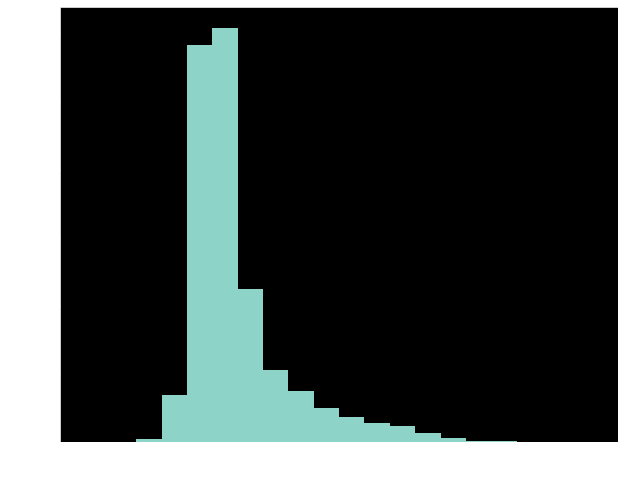

Shapiro-Wilk Test
-----------------
Provided an alpha of 0.05, if p-value > alpha then the distribution can be assumed to be normal.
This test prunes data to the first 5000 data points or "head(5000)" as reliability suffers with increasing samples.
t-stat: 0.6654062867164612 , p-value: 0.0

Anderson-Darling Test
---------------------
If the returned statistic > critical values then for the corresponding significance level,
the null hypothesis that the data come from the chosen distribution can be rejected.
t-stat: 10910.59739584144 , critical values: [0.576 0.656 0.787 0.918 1.092] , at significance levels of: [15.  10.   5.   2.5  1. ]

Skewness and Kurtosis
---------------------
skewness, -ve skews left and +ve skews right (0 is best): 2.32689942902098
kurtosis, tail spread (< 3 is best): 5.215487610741231


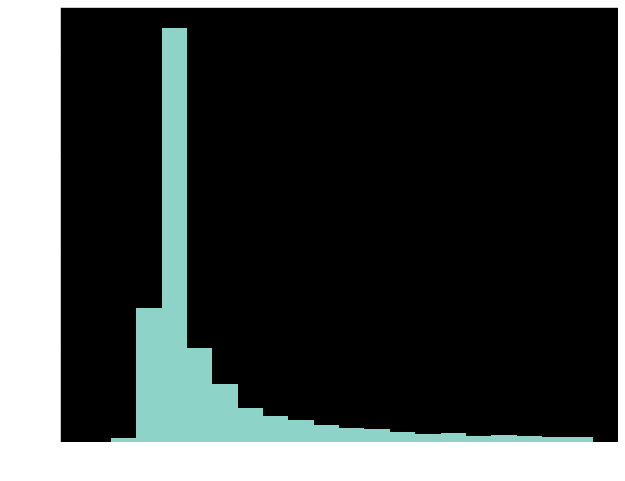

,dep_delay,arr_delay
count,91502.000000,91502.000000
mean,9.956176,5.643308
std,27.637826,31.450826
min,-32.000000,-88.000000
25%,-5.000000,-13.000000
50%,-1.000000,-4.000000
75%,12.000000,13.000000
max,135.000000,227.000000


In [12]:
sc.check_normal_dist(df['arr_delay'])
sc.check_normal_dist(df['dep_delay'])
df.describe()

These are much better. The mean trends closer to zeo, and the max values aren't nearly so bad. Though, it still skews positive, these numbers make more sense.

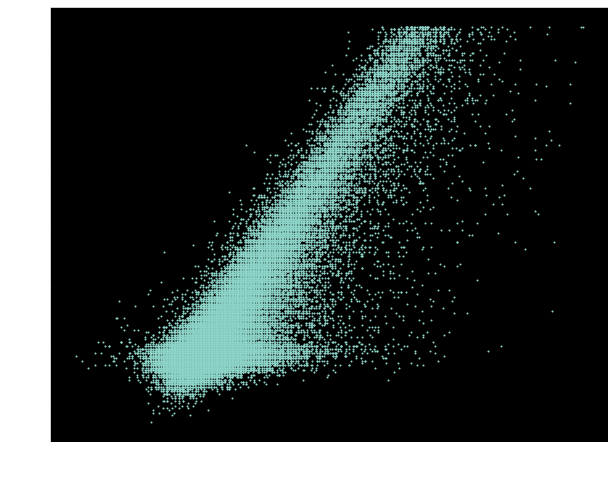

In [13]:
sc.graph_eda('scatter', df['arr_delay'], df['dep_delay'], marker_size=1)

There appears to be a correlation between the two, arr_delay and dep_delay. What's interesting is that the effect of departure delays on arrival delays appear to be wide one way. Arrival delay is less correlated to departure than the other way around.

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

##### Define a function that takes samples per time period

In [14]:
# search for columns that describe delays
regex = r"(.*date.*)"

for i, table in enumerate(df_table_names):
    indices, results = sc.search_data(table, regex)
    # print(i)
    # print(indices)
    print(results)

['fl_date']
['fl_date']
[]
[]
[]
['fl_date']
['fl_date']


Only one column with associated dates. Take 100k samples from each month.

In [29]:
df_flights_by_month = []

for i in range(0,12):
    df_flights_by_month.append(sc.sql_search_date(table='flights', y=2019, m=i+1).sort_values(by='fl_date'))

File exists. Returning DataFrame...
Writing file...
Returning DataFrame...
Writing file...
Returning DataFrame...
Writing file...
Returning DataFrame...
Writing file...
Returning DataFrame...
Writing file...
Returning DataFrame...
Writing file...
Returning DataFrame...
Writing file...
Returning DataFrame...
Writing file...
Returning DataFrame...
Writing file...
Returning DataFrame...
Writing file...
Returning DataFrame...
Writing file...
Returning DataFrame...


In [30]:
df_flights_by_month

[        fl_date mkt_unique_carrier branded_code_share mkt_carrier  \
 454  2019-01-01                 AA                 AA          AA   
 34   2019-01-01                 DL       DL_CODESHARE          DL   
 800  2019-01-01                 AA                 AA          AA   
 474  2019-01-01                 AA       AA_CODESHARE          AA   
 46   2019-01-01                 WN                 WN          WN   
 ..          ...                ...                ...         ...   
 264  2019-01-31                 AA       AA_CODESHARE          AA   
 244  2019-01-31                 UA       UA_CODESHARE          UA   
 177  2019-01-31                 AA                 AA          AA   
 635  2019-01-31                 UA       UA_CODESHARE          UA   
 0    2019-01-31                 UA       UA_CODESHARE          UA   
 
      mkt_carrier_fl_num op_unique_carrier tail_num  op_carrier_fl_num  \
 454                2522                AA   N836NN               2522   
 34       

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [17]:
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-07-16,AA,AA_CODESHARE,AA,4702,YX,N443YX,4702,10397,ATL,...,547.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-07-16,AA,AA_CODESHARE,AA,4702,YX,N443YX,4702,11278,DCA,...,547.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-16,AA,AA_CODESHARE,AA,4703,YX,N417YX,4703,12953,LGA,...,292.0,0.0,0.0,33.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2019-07-16,AA,AA_CODESHARE,AA,4704,YX,N125HQ,4704,11278,DCA,...,323.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-07-16,AA,AA_CODESHARE,AA,4705,YX,N410YX,4705,12451,JAX,...,742.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
pd.merge(df_flights.head(), df_flights.tail(), how='outer')

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-07-16,AA,AA_CODESHARE,AA,4702,YX,N443YX,4702,10397,ATL,...,547.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-07-16,AA,AA_CODESHARE,AA,4702,YX,N443YX,4702,11278,DCA,...,547.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-16,AA,AA_CODESHARE,AA,4703,YX,N417YX,4703,12953,LGA,...,292.0,0.0,0.0,33.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2019-07-16,AA,AA_CODESHARE,AA,4704,YX,N125HQ,4704,11278,DCA,...,323.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-07-16,AA,AA_CODESHARE,AA,4705,YX,N410YX,4705,12451,JAX,...,742.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-07-20,AA,AA,AA,2136,AA,N945UW,2136,12953,LGA,...,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2019-07-20,AA,AA,AA,2139,AA,N945UW,2139,10721,BOS,...,399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-07-20,AA,AA,AA,2143,AA,N949UW,2143,11278,DCA,...,214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2019-07-20,AA,AA,AA,2149,AA,N945UW,2149,11278,DCA,...,399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2019-07-20,AA,AA,AA,2169,AA,N947UW,2169,10721,BOS,...,399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?